<a href="https://colab.research.google.com/github/JMIGUELCOR/Aplicadas_1/blob/main/ModeloDemanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pronóstico de Demanda Energética en Cali mediante Redes Neuronales

* **Autores:**

> [Laura Sofia Fernandez](https://github.com/#)

> [Juan Jose Navas](https://github.com/#)

> [Juan Camilo Libreros](https://github.com/#)

> [Juan Miguel Correa](https://github.com/JMIGUELCOR)

## Resumen Ejecutivo

En este proyecto se aborda el pronóstico de la demanda energética en el Mercado de Comercialización Operativo de Cali (MC‑Cali) utilizando una red neuronal. Se presentan los fundamentos matemáticos de las redes neuronales, incluyendo la formulación del perceptrón, funciones de activación y el algoritmo de backpropagation. Los datos históricos de demanda horaria se procesan y escalan antes de entrenar una red neuronal de arquitectura de múltiples capas densas. Los resultados se comparan con el pronóstico existente calculando el error cuadrático medio (MSE) y mostrando la curva de aprendizaje, evidenciando la capacidad de la red para captar relaciones no lineales. Finalmente, se discuten las limitaciones del enfoque univariado y se proponen mejoras, como la incorporación de variables climáticas y de calendario.

## Introducción

La demanda energética en Cali presenta patrones diarios y estacionales derivados de la actividad industrial, el clima y los hábitos de consumo residencial. Un pronóstico preciso es esencial para la planificación operativa, la optimización de recursos y la estabilidad del sistema eléctrico. Los métodos tradicionales basados en modelos estadísticos lineales pueden quedarse cortos al no capturar la complejidad no lineal de los datos.

Las redes neuronales ofrecen un marco matemático robusto que combina:

Funciones de activación para introducir no linealidad,

Ponderaciones y sesgos para modelar relaciones complejas,

Descenso por gradiente y backpropagation para ajustar parámetros minimizando una función de pérdida.

Este trabajo demuestra cómo aplicar estos conceptos de cálculo y álgebra lineal a un problema real de pronóstico energético en MC‑Cali, implementando y evaluando una red neuronal que mejore el error de predicción en comparación con el modelo de referencia.

## 1. Librerías

In [9]:
import pandas as pd
from datetime import date
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##  2. Preprocesamiento de los datos

### 2.1. Carga y filtrado

In [10]:
# Cargar CSV y parsear fechas
df = pd.read_csv("DatasetDemanda.csv", parse_dates=["Fecha"])

# Filtrar mercado MC-Cali y columnas relevantes
df_cali = df[df["MercadoComercializacionOperativo"] == "MC-Cali"][["Fecha","Periodo","DemandaAtendida","PronDem"]].copy()

# Renombrar
df_cali.rename(columns={"DemandaAtendida":"Demanda_GWh","PronDem":"Pronostico_Existente"}, inplace=True)

# Ordenar y reset index
df_cali.sort_values(["Fecha","Periodo"], inplace=True)
df_cali.reset_index(drop=True, inplace=True)


print("Dimensiones del dataset de Cali:", df_cali.shape)
df_cali.head(24)

Dimensiones del dataset de Cali: (26328, 4)


,Fecha,Periodo,Demanda_GWh,Pronostico_Existente
0,2022-01-01,1,322157.50,302369.25
1,2022-01-01,2,308205.09,285758.78
2,2022-01-01,3,294792.88,275533.38
3,2022-01-01,4,284245.22,266873.06
4,2022-01-01,5,275957.66,264517.75
5,2022-01-01,6,270163.81,261633.14
6,2022-01-01,7,245016.73,250302.53
7,2022-01-01,8,244611.28,261504.52
8,2022-01-01,9,256023.02,282573.72
9,2022-01-01,10,269045.56,302307.50


### 2.2 Agrupación diaria y variables

In [11]:
# Fecha a ordinal
df_cali['FechaOrdinal'] = df_cali['Fecha'].map(pd.Timestamp.toordinal)

# Agrupar por día
df_diario = df_cali.groupby('FechaOrdinal').agg({
    'Demanda_GWh':'mean',
    'Pronostico_Existente':'mean'
}).reset_index()

# Convertir ordinal a timestamp
fechas = pd.to_datetime(df_diario['FechaOrdinal'].map(pd.Timestamp.fromordinal))

# Ingeniería de variables
df_diario['DayOfYear'] = fechas.dt.dayofyear
df_diario['sin_dia'] = np.sin(2*np.pi*df_diario['DayOfYear']/365)
df_diario['cos_dia'] = np.cos(2*np.pi*df_diario['DayOfYear']/365)

# Media móvil 7 días
df_diario['MA_7'] = df_diario['Demanda_GWh'].rolling(7, center=True).mean().bfill().ffill()

### 2.3 Escalado y división

In [12]:
# Transformar target
df_diario['Demanda_log'] = np.log1p(df_diario['Demanda_GWh'])

# Selección de features y target
feature_cols = ['FechaOrdinal','sin_dia','cos_dia','MA_7','Pronostico_Existente']
target_col = ['Demanda_log']

# Escaladores
scaler_X = MinMaxScaler(); scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df_diario[feature_cols])
y = scaler_y.fit_transform(df_diario[target_col])

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

# Tensores y loaders
torch_X_train = torch.from_numpy(X_train.astype(np.float32))
torch_y_train = torch.from_numpy(y_train.astype(np.float32))
torch_X_test  = torch.from_numpy(X_test.astype(np.float32))
torch_y_test  = torch.from_numpy(y_test.astype(np.float32))
train_loader = DataLoader(TensorDataset(torch_X_train,torch_y_train), batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(torch_X_test, torch_y_test),  batch_size=64, shuffle=False)

## 3. Construcción de la red neuronal

### 3.1 Definición del MLP

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(16),
            nn.Dropout(0.1),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

In [14]:
SEED = 45
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 3.2 Instanciación

In [16]:
input_dim = len(feature_cols)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

## 4. Entrenamiento

In [18]:
epochs = 500
train_losses, val_losses = [], []

best_val, patience, counter = float('inf'), 30, 0

for epoch in range(1, epochs+1):
    # Entrenamiento
    model.train(); run_tr=0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(); loss=criterion(model(xb), yb)
        loss.backward(); optimizer.step(); run_tr+=loss.item()*xb.size(0)
    train_losses.append(run_tr/len(train_loader.dataset))


    # Validación
    model.eval(); run_v=0
    with torch.no_grad():
        for xb,yb in test_loader:
            xb,yb=xb.to(device), yb.to(device)
            run_v+=criterion(model(xb), yb).item()*xb.size(0)
    val_losses.append(run_v/len(test_loader.dataset))


    # Early stopping
    if val_losses[-1] < best_val - 1e-6:
        best_val, counter = val_losses[-1], 0
    else:
        counter+=1
        if counter>=patience:
            print(f"Early stopping en epoch {epoch}")
            break


    # Log cada 20 epochs
    if epoch==1 or epoch%20==0:
        print(f"Ep {epoch}/{epochs} - Tr: {train_losses[-1]:.4f} Val: {val_losses[-1]:.4f}")


Ep 1/500 - Tr: 0.0064 Val: 0.0161
Ep 20/500 - Tr: 0.0061 Val: 0.0109
Ep 40/500 - Tr: 0.0060 Val: 0.0104
Ep 60/500 - Tr: 0.0057 Val: 0.0121
Ep 80/500 - Tr: 0.0054 Val: 0.0095
Ep 100/500 - Tr: 0.0051 Val: 0.0118
Ep 120/500 - Tr: 0.0051 Val: 0.0055
Ep 140/500 - Tr: 0.0052 Val: 0.0054
Ep 160/500 - Tr: 0.0051 Val: 0.0056
Early stopping en epoch 162


## 5. Visualización y evaluación

### 5.1 Curvas y predicción

In [19]:
model.eval(); preds=[]
with torch.no_grad():
    for xb,_ in test_loader:
        preds.append(model(xb.to(device)).cpu().numpy())
preds = np.vstack(preds)

### 5.2 Invertir escalado y log

In [20]:
y_true_log = scaler_y.inverse_transform(torch_y_test.numpy())
y_pred_log = scaler_y.inverse_transform(preds)
y_true = np.expm1(y_true_log).flatten()
y_pred = np.expm1(y_pred_log).flatten()

### 5.3 Fechas

In [21]:
dates = pd.to_datetime(df_diario['FechaOrdinal'].map(pd.Timestamp.fromordinal))
split = len(df_diario)-len(y_true)
dates_test = dates.iloc[split:].reset_index(drop=True)

### 5.4 Plot

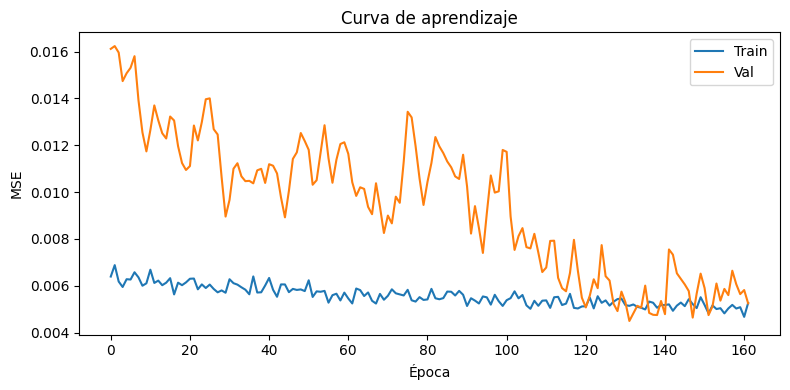

In [22]:
plt.figure(figsize=(8,4))
plt.plot(train_losses,label='Train')
plt.plot(val_losses,label='Val')
plt.title('Curva de aprendizaje')
plt.xlabel('Época'); plt.ylabel('MSE')
plt.legend(); plt.tight_layout()
plt.show()

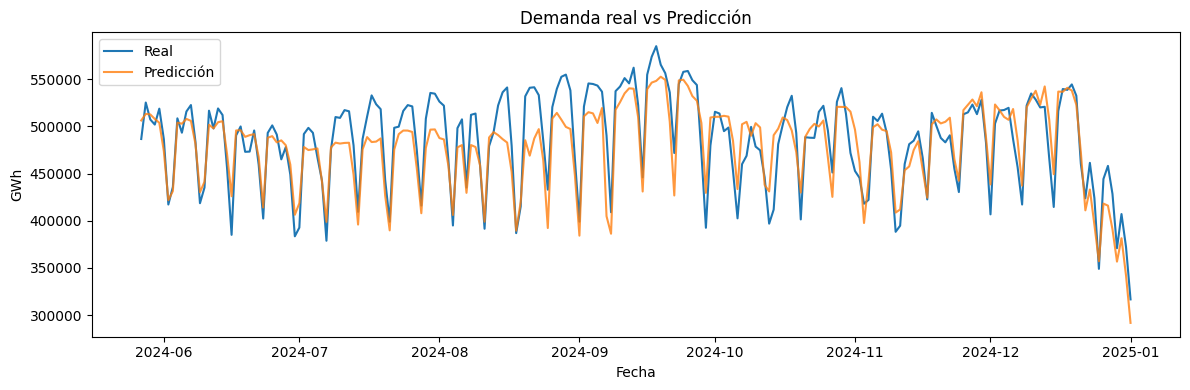

In [23]:
plt.figure(figsize=(12,4));
plt.plot(dates_test,y_true,label='Real')
plt.plot(dates_test,y_pred,label='Predicción',alpha=0.8)
plt.title('Demanda real vs Predicción'); plt.xlabel('Fecha')
plt.ylabel('GWh'); plt.legend(); plt.tight_layout()
plt.show()

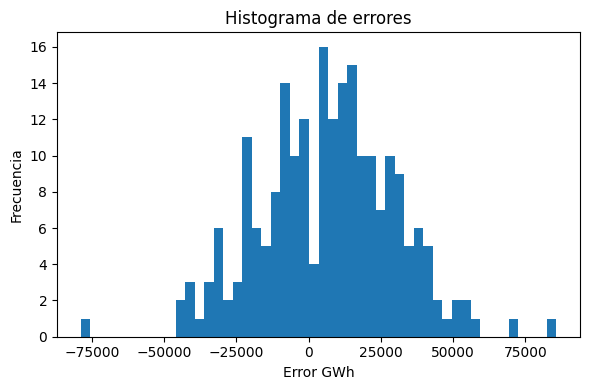

In [24]:
plt.figure(figsize=(6,4))
plt.hist(y_true-y_pred,bins=50)
plt.title('Histograma de errores')
plt.xlabel('Error GWh'); plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

### 5.5 Evaluación de métricas

In [28]:
mse_nn = mean_squared_error(y_true, y_pred)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_true, y_pred)
r2_nn = r2_score(y_true, y_pred)
mean_demanda = np.mean(y_true)

In [31]:
print("\nMétricas de Evaluación:")
print(f"MSE: {mse_nn:.2f}")
print(f'RSE: {rmse_nn:.2f}')
print(f"MAE: {mae_nn:.2f}")
print(f"R²: {r2_nn:.2f}")


Métricas de Evaluación:
MSE: 593888064.00
RSE: 24369.82
MAE: 19556.87
R²: 0.76


In [32]:
tolerancia = mse_nn / (mean_demanda**2) * 100
print(f"Tolerancia del modelo: {tolerancia:.4f}%")

Tolerancia del modelo: 0.2520%
